In [1]:
import math
import os
import csv
import json
import requests
import random
import matplotlib.pylab as plt
import numpy as np
import cv2
import pickle

from os import path as osp
from PIL import Image, ImageDraw
from urllib.request import urlretrieve
from k12libs.utils.nb_easy import k12ai_get_top_dir, RACEURL
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from k12libs.utils.nb_easy import k12ai_set_notebook

In [2]:
cv2.__version__

'4.4.0'

In [3]:
k12ai_set_notebook(cellw=90)

In [226]:
def im_show(img, gray=False, bgr=False):
    plt.figure(figsize=(8,8))
    plt.axis('off')
    if bgr:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
        
    if gray:
        plt.imshow(img, cmap=plt.cm.gray)
    else:
        plt.imshow(img)

## show 9 images

In [399]:
dataset_root = osp.join('/data/datasets/cv/dobble')
images_root = osp.join(dataset_root, 'icons')
!ls $images_root

0.png	16.png	23.png	30.png	38.png	45.jpeg  52.jpg   6.png   67.jpg  8.png
1.png	17.png	24.png	31.png	39.png	46.jpg	 53.jpeg  60.jpg  68.jpg  9.png
10.png	18.png	25.png	32.png	4.png	47.jpg	 54.jpeg  61.jpg  69.jpg
11.png	19.png	26.png	33.png	40.png	48.jpg	 55.jpeg  62.jpg  7.png
12.png	2.png	27.png	34.png	41.png	49.jpg	 56.jpeg  63.jpg  70.jpg
13.png	20.png	28.png	35.png	42.jpg	5.png	 57.jpeg  64.jpg  71.jpg
14.png	21.png	29.png	36.png	43.jpg	50.jpg	 58.jpeg  65.jpg  72.jpg
15.png	22.png	3.png	37.png	44.jpg	51.jpg	 59.jpeg  66.jpg  73.jpg


In [401]:
image9_files = os.listdir(images_root)[:9]
images9 = [Image.open(osp.join(images_root, fname)) for fname in image9_files]

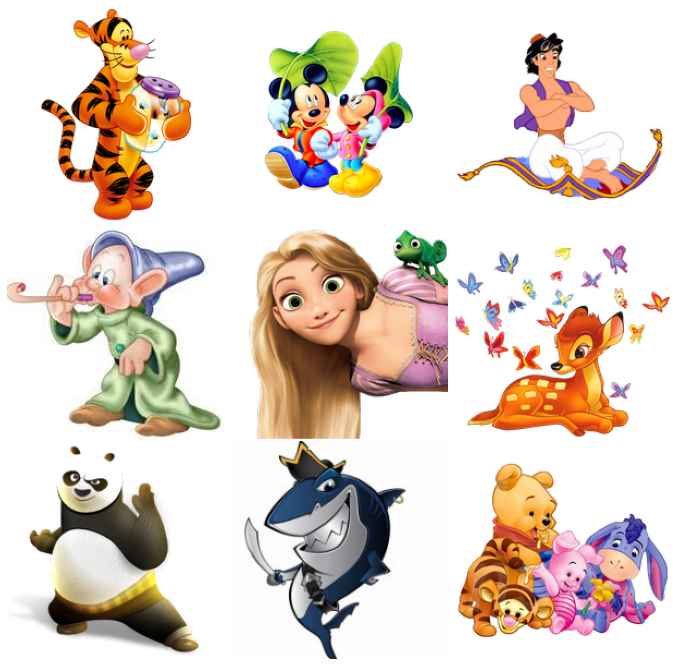

In [402]:
random.shuffle(images9)
nrow, ncol = 3, 3
fig = plt.figure(figsize=(4*nrow, 4*ncol))
for i in range(nrow*ncol):
    ax = fig.add_subplot(nrow, ncol, i+1)
    plt.axis('off')
    plt.imshow(images9[i])
plt.subplots_adjust(wspace =0, hspace =0)

## Generate 73 cards

计算两个圆环之间最大的正方形的边长

$$ 
L = 2x = 2 * \dfrac{-2r + \sqrt{5R^2 - r^2}}{5}
$$

In [437]:
def generate_card(size, ratio_1, ratio_2, images, outpath, debug=False):
    imgs = images.copy()
    
    R0 = round(size / 2)      # 最外环半径
    R1 = int(R0 * ratio_1)    # 中间环半径
    R2 = round(R1 * ratio_2)  # 中心环半径
    
    card = Image.new('RGBA', (2*R0, 2*R0))
    draw = ImageDraw.Draw(card)
    draw.ellipse((0, 0, card.width-1, card.height-1),
                 fill='#FFFFFF', outline='#000000')
    
    # 圆环
    if debug:
        draw.ellipse((0, 0, 2*R0, 2*R0), fill=None, outline='#FF0000')
        draw.text((30, 30), f'R0:{R0}', (255, 0, 0), width=4)

        draw.ellipse((R0-R1, R0-R1, R0+R1, R0+R1), fill=None, outline='#00FF00')
        draw.text((R0-R1+30, R0-R1+30), f'R1:{R1}', (0, 255, 0), width=4)

        draw.ellipse((R0-R2, R0-R2, R0+R2, R0+R2), fill=None, outline='#0000FF')
        draw.text((R0-R2+10, R0-R2+10), f'R2:{R2}', (0, 0, 255), width=4)
    
    # 环内正方形的中心
    if debug:
        r1_c = R2 + (R1 - R2) / 2
        r2_c = R1 + (R0 - R1) / 2
        draw.ellipse((R0-r1_c, R0-r1_c, R0+r1_c, R0+r1_c), fill=None, outline='#000FF0')
        draw.text((R0-r1_c+10, R0-r1_c+10), f'r1_c:{r1_c}', (0, 0, 255), width=4)

        draw.ellipse((R0-r2_c, R0-r2_c, R0+r2_c, R0+r2_c), fill=None, outline='#00F0F0')
        draw.text((R0-r2_c+50, R0-r2_c+50), f'r2_c:{r2_c}', (0, 0, 255), width=4)
    
    # 正方形的边长
    box_edge1 = 2 * round((-2*R2 + math.sqrt(5*R1*R1 - R2*R2)) / 5) # 内部正方形
    box_edge2 = 2 * round((-2*R1 + math.sqrt(5*R0*R0 - R1*R1)) / 5) # 外部正方形
    
    # 计算左上顶点
    box_xy1 = R0 + R2, R0 - round(box_edge1/2) 
    box_xy2 = R0 + R1, R0 - round(box_edge2/2) 
    
    def _paste_icon(card, box_xy, edge, num):
        angle = int(360 / num)
        for idx in range(num):
            scale = random.uniform(0.6, 0.98)
            size = round(scale*edge), round(scale*edge)
            img = Image.open(imgs.pop()).convert("RGBA")  
            img = img.resize(size, Image.ANTIALIAS).rotate(random.randrange(0, 360), resample=Image.BICUBIC)
            card.paste(img, box=box_xy, mask=img)
            card = card.rotate(angle, resample=Image.BICUBIC) 
        return card
    
    # 内圈3个ICON
    card = _paste_icon(card, box_xy1, box_edge1, 3)
        
    card = card.rotate(random.randint(10, 40), resample=Image.BICUBIC) 
    
    # 外圈6个ICON
    card = _paste_icon(card, box_xy2, box_edge2, 6)
    
    # 保存
    card.save(outpath, dpi=(600, 600), format='PNG', subsampling=0, quality=100)
    return card

## Generate 73 cards

In [438]:
cards_seqs = [
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [0, 9, 10, 11, 12, 13, 14, 15, 16],
    [0, 17, 18, 19, 20, 21, 22, 23, 24],
    [0, 25, 26, 27, 28, 29, 30, 31, 32],
    [0, 33, 34, 35, 36, 37, 38, 39, 40],
    [0, 41, 42, 43, 44, 45, 46, 47, 48],
    [0, 49, 50, 51, 52, 53, 54, 55, 56],
    [0, 57, 58, 59, 60, 61, 62, 63, 64],
    [0, 65, 66, 67, 68, 69, 70, 71, 72],
    [1, 9, 17, 25, 33, 41, 49, 57, 65],
    [1, 10, 18, 26, 34, 42, 50, 58, 66],
    [1, 11, 19, 27, 35, 43, 51, 59, 67],
    [1, 12, 20, 28, 36, 44, 52, 60, 68],
    [1, 13, 21, 29, 37, 45, 53, 61, 69],
    [1, 14, 22, 30, 38, 46, 54, 62, 70],
    [1, 15, 23, 31, 39, 47, 55, 63, 71],
    [1, 16, 24, 32, 40, 48, 56, 64, 72],
    [2, 9, 18, 27, 36, 45, 54, 63, 72],
    [2, 10, 17, 28, 35, 46, 53, 64, 71],
    [2, 11, 20, 25, 34, 47, 56, 61, 70],
    [2, 12, 19, 26, 33, 48, 55, 62, 69],
    [2, 13, 22, 31, 40, 41, 50, 59, 68],
    [2, 14, 21, 32, 39, 42, 49, 60, 67],
    [2, 15, 24, 29, 38, 43, 52, 57, 66],
    [2, 16, 23, 30, 37, 44, 51, 58, 65],
    [3, 9, 19, 29, 39, 46, 56, 58, 68],
    [3, 10, 20, 30, 40, 45, 55, 57, 67],
    [3, 11, 17, 31, 37, 48, 54, 60, 66],
    [3, 12, 18, 32, 38, 47, 53, 59, 65],
    [3, 13, 23, 25, 35, 42, 52, 62, 72],
    [3, 14, 24, 26, 36, 41, 51, 61, 71],
    [3, 15, 21, 27, 33, 44, 50, 64, 70],
    [3, 16, 22, 28, 34, 43, 49, 63, 69],
    [4, 9, 20, 31, 38, 42, 51, 64, 69],
    [4, 10, 19, 32, 37, 41, 52, 63, 70],
    [4, 11, 18, 29, 40, 44, 49, 62, 71],
    [4, 12, 17, 30, 39, 43, 50, 61, 72],
    [4, 13, 24, 27, 34, 46, 55, 60, 65],
    [4, 14, 23, 28, 33, 45, 56, 59, 66],
    [4, 15, 22, 25, 36, 48, 53, 58, 67],
    [4, 16, 21, 26, 35, 47, 54, 57, 68],
    [5, 9, 21, 30, 34, 48, 52, 59, 71],
    [5, 10, 22, 29, 33, 47, 51, 60, 72],
    [5, 11, 23, 32, 36, 46, 50, 57, 69],
    [5, 12, 24, 31, 35, 45, 49, 58, 70],
    [5, 13, 17, 26, 38, 44, 56, 63, 67],
    [5, 14, 18, 25, 37, 43, 55, 64, 68],
    [5, 15, 19, 28, 40, 42, 54, 61, 65],
    [5, 16, 20, 27, 39, 41, 53, 62, 66],
    [6, 9, 22, 32, 35, 44, 55, 61, 66],
    [6, 10, 21, 31, 36, 43, 56, 62, 65],
    [6, 11, 24, 30, 33, 42, 53, 63, 68],
    [6, 12, 23, 29, 34, 41, 54, 64, 67],
    [6, 13, 18, 28, 39, 48, 51, 57, 70],
    [6, 14, 17, 27, 40, 47, 52, 58, 69],
    [6, 15, 20, 26, 37, 46, 49, 59, 72],
    [6, 16, 19, 25, 38, 45, 50, 60, 71],
    [7, 9, 23, 26, 40, 43, 53, 60, 70],
    [7, 10, 24, 25, 39, 44, 54, 59, 69],
    [7, 11, 21, 28, 38, 41, 55, 58, 72],
    [7, 12, 22, 27, 37, 42, 56, 57, 71],
    [7, 13, 19, 30, 36, 47, 49, 64, 66],
    [7, 14, 20, 29, 35, 48, 50, 63, 65],
    [7, 15, 17, 32, 34, 45, 51, 62, 68],
    [7, 16, 18, 31, 33, 46, 52, 61, 67],
    [8, 9, 24, 28, 37, 47, 50, 62, 67],
    [8, 10, 23, 27, 38, 48, 49, 61, 68],
    [8, 11, 22, 26, 39, 45, 52, 64, 65],
    [8, 12, 21, 25, 40, 46, 51, 63, 66],
    [8, 13, 20, 32, 33, 43, 54, 58, 71],
    [8, 14, 19, 31, 34, 44, 53, 57, 72],
    [8, 15, 18, 30, 35, 41, 56, 60, 69],
    [8, 16, 17, 29, 36, 42, 55, 59, 70]
]

images73_files = os.listdir(images_root)
images73 = [osp.join(images_root, fname) for fname in images73_files[:73]]
os.makedirs(f'{dataset_root}/imgs', exist_ok=True)
outfiles = []
for i, seq in enumerate(cards_seqs):
    images9 = [images73[j] for j in seq]
    outfiles.append(f'{dataset_root}/imgs/{i}.png')
    # generate_card(1024, 0.42, 0.2, images9, outfiles[-1])

## Sift Features

In [469]:
# pickle

# Pickling cv2.KeyPoint causes PicklingError
# https://stackoverflow.com/questions/10045363/pickling-cv2-keypoint-causes-picklingerror

def generate_sift_features(images, outpath):
    import copyreg
    def _pickle_keypoints(point):
        return cv2.KeyPoint, (*point.pt, point.size, point.angle,
                              point.response, point.octave, point.class_id)
    copyreg.pickle(cv2.KeyPoint().__class__, _pickle_keypoints)
    feature_items = {}
    for imgpath in images:
        key = osp.basename(imgpath).split('.')[0]
        img = cv2.imread(imgpath)
        sift = cv2.xfeatures2d.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(img, None)
        feature_items[key] = (keypoints, descriptors)
        
    with open(outpath, 'wb') as fw:
        pickle.dump(feature_items, fw)

outpath = f'{dataset_root}/keypoints_descriptors.sift'
generate_sift_features(images73, outpath)

with open(outpath, 'rb') as fr:
    feature_items_ = pickle.load(fr)

In [531]:
class CV2Image(object):
    def __init__(self):
        pass
    
    @staticmethod
    def resize(img, size):
        return cv2.resize(img, size)
    
    @staticmethod
    def rotate(img, angle, scale=1.0, center=None):
        (h, w) = img.shape[:2]
        if center is None:
            center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, scale)
        return cv2.warpAffine(img, M, (w, h))
        
    @staticmethod
    def gaussian_blur(img, ksize=(11, 11)):
        return cv2.GaussianBlur(img, ksize, 0)
    
    @staticmethod
    def median_blur(img, ksize=5):
        return cv2.medianBlur(img, ksize)
    
    @staticmethod
    def contrast(img, clip_limit=3.0, tile_grid_size=(8,8)):
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        cl = clahe.apply(l)
        limg = cv2.merge((cl,a,b))
        return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    @staticmethod
    def to_gray(img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    @staticmethod
    def to_rgb(img, alpha=True):
        if alpha:
            return cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    @staticmethod
    def to_thresh(img, threshold=190):                                
        return cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)[1]
    
    @staticmethod
    def to_canny(img, thresh1=75, thresh2=200):
        return cv2.Canny(img, thresh1, thresh2)
    
    @staticmethod
    def show(img, figsize=(8, 8), gray=False, isbgr=True):
        plt.figure(figsize=figsize)
        plt.axis('off')
        if isbgr:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
        if gray:
            plt.imshow(img, cmap=plt.cm.gray)
        else:
            plt.imshow(img)

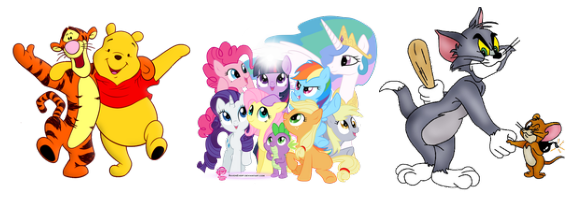

In [473]:
N = 3
def gen_sample_images(n=2):
    random.shuffle(images73)
    return [(osp.basename(f).split('.')[0], cv2.imread(f, cv2.IMREAD_UNCHANGED)) for f in images73[:n]]
samples = gen_sample_images(N)

nrow, ncol = int(N/3), 3
fig = plt.figure(figsize=(10*nrow, 5*ncol))
for i in range(nrow*ncol):
    ax = fig.add_subplot(nrow, ncol, i+1)
    plt.axis('off')
    plt.imshow(CV2Image.to_rgb(samples[i][1], alpha=True))
plt.subplots_adjust(wspace =0, hspace =0)

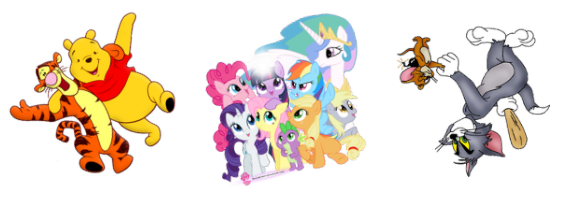

In [477]:
samples_changed = []
for title, img in samples:
    img_changed = CV2Image.rotate(img, random.randint(10, 350), scale=(0.6 + random.random()*0.4))
    samples_changed.append((title, img_changed))
    
nrow, ncol = int(N/3), 3
fig = plt.figure(figsize=(10*nrow, 5*ncol))
for i in range(nrow*ncol):
    ax = fig.add_subplot(nrow, ncol, i+1)
    plt.axis('off')
    plt.imshow(CV2Image.to_rgb(samples_changed[i][1], alpha=True))
plt.subplots_adjust(wspace =0, hspace =0)

In [497]:
def calculate_matches(matcher, des1, des2):
    matches = matcher.knnMatch(des1, des2, k=2)
    topResults1 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults1.append([m])
            
    matches = matcher.knnMatch(des2, des1, k=2)
    topResults2 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults2.append([m])
    
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults


def sift_best_match(img, features):
    sift = cv2.xfeatures2d.SIFT_create()
    kp_1, desc_1 = sift.detectAndCompute(img, None)
    index_params = dict(algorithm=0, trees=5)
    search_params = dict()
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    result = []
    for title, (keypoints, descriptors) in features.items():
        kp_2, desc_2 = keypoints, descriptors
        matches = calculate_matches(flann, desc_1, desc_2)
        score = 100 * (len(matches) / min(len(kp_1), len(kp_2)))
        result.append((score, title)) 
    return max(result, key=lambda x: x[0])

for title_org, img_org in samples_changed:
    result = sift_best_match(img_org, feature_items_)
    print(title_org, 'vs', result[1], 'score:', result[0])

0 vs 0 score: 47.863247863247864
30 vs 30 score: 56.187290969899664
33 vs 33 score: 63.101604278074866


## Contours

In [503]:
files = [osp.join(f'{dataset_root}/imgs', f) for f in os.listdir(f'{dataset_root}/imgs')]
img_org = cv2.imread(files[0], cv2.IMREAD_UNCHANGED) # IMREAD_UNCHANGED read Alpha

### 原图

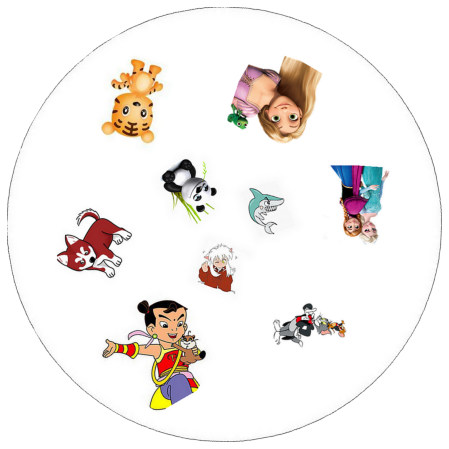

In [508]:
CV2Image.show(img_org, isbgr=True)

### 增强对比度

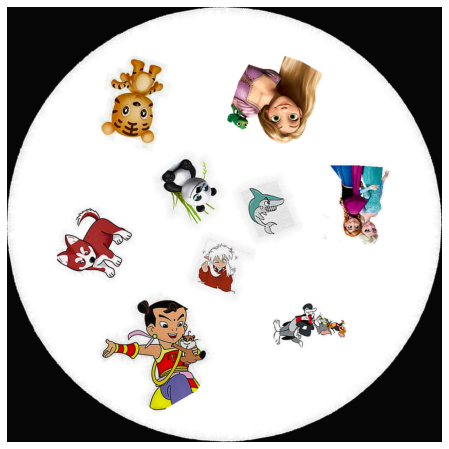

In [520]:
img_contrast = CV2Image.contrast(img_org)
CV2Image.show(img_contrast)

### 修改大小

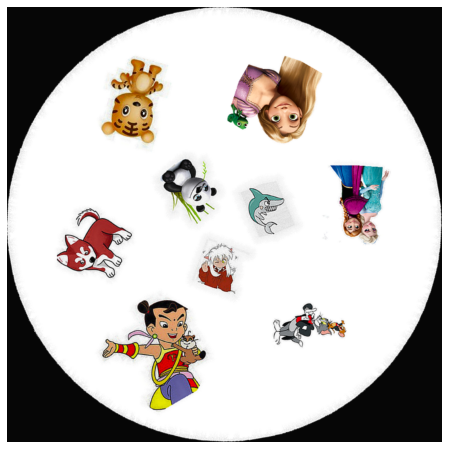

In [523]:
img_resize800 = CV2Image.resize(img_contrast, size=(800, 800))
CV2Image.show(img_resize800)

### 高斯滤波

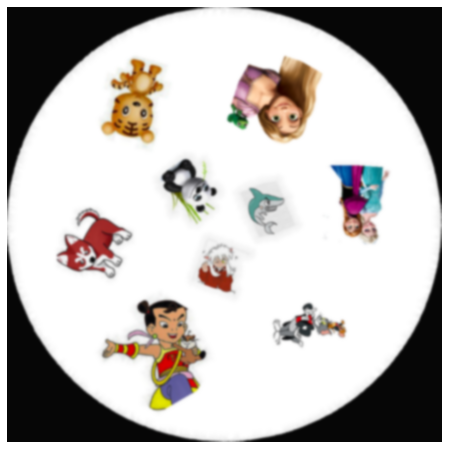

In [526]:
img_gaussian = CV2Image.gaussian_blur(img_resize800, ksize=(11, 11))
CV2Image.show(img_gaussian)

### 中值滤波

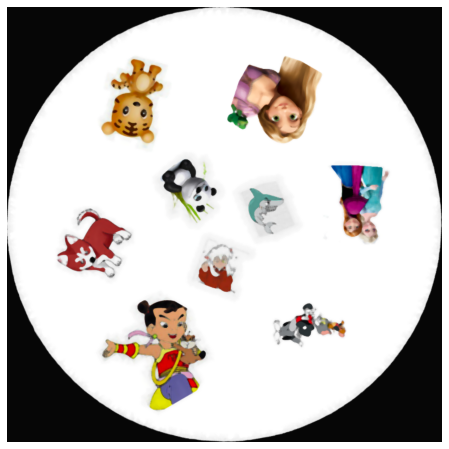

In [527]:
img_median = CV2Image.median_blur(img_resize800, ksize=5)
CV2Image.show(img_median)

### 灰度

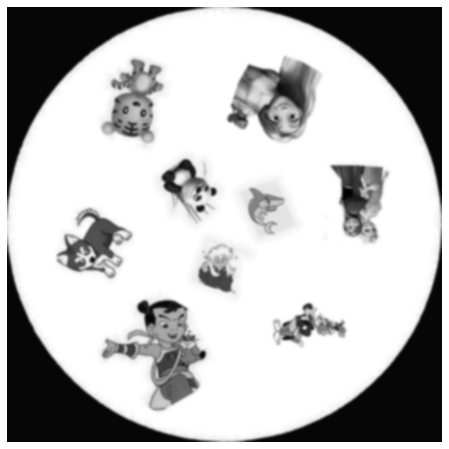

In [536]:
img_gray = CV2Image.to_gray(img_gaussian)
CV2Image.show(img_gray, gray=True)

### 二值滤波

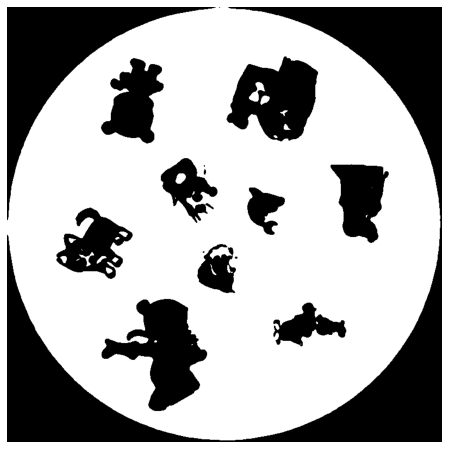

In [537]:
img_bin = CV2Image.to_thresh(img_gray, threshold=210)
CV2Image.show(img_bin, gray=True)

### 边缘检测

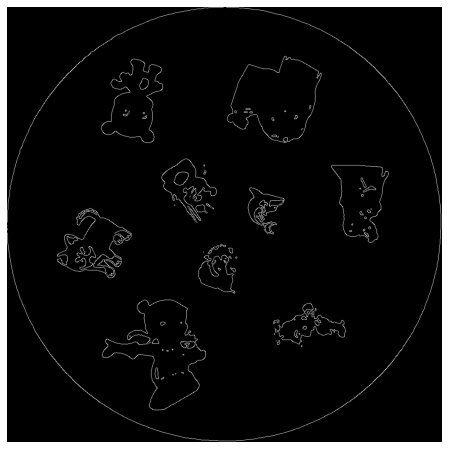

In [516]:
img_canny = CV2Image.to_canny(img_bin)
CV2Image.show(img_canny, gray=True)

### 轮廓检测

In [545]:
class CV2Contour(object):
    def __init__(self):
        pass
    
    @staticmethod
    def make_white_background(img, contour):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = np.zeros(gray.shape, np.uint8)
        mask = cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        fg_masked = cv2.bitwise_and(img, img, mask=mask)
        mask = cv2.bitwise_not(mask)
        bg = np.full(img.shape, 255, dtype=np.uint8)
        bg_masked = cv2.bitwise_and(bg, bg, mask=mask)
        return cv2.bitwise_or(fg_masked, bg_masked)
    
    @staticmethod
    def make_out_roi(img, contour, square=False):
        x, y, w, h = cv2.boundingRect(contour)
        if square:
            if w < h:
                x += int((w-h)/2)
                w = h
            else:
                y += int((h-w)/2)
                h = w               
        return img[y:y+h, x:x+w] 
    
    @staticmethod
    def on_draw(img, contour, rect=False):
        if rect:
            x, y, w, h = cv2.boundingRect(contour)
            contour_image = cv2.rectangle(img, (x, y), (x+w, y+h), color = (255, 0, 0), thickness = 2)
        else:
            contour_image = cv2.drawContours(img, [contour], -1, (255, 0, 0), 3)
        return contour_image
    
    def grab_by_area(img, tree=False, area=False):
        if tree:
            cnts, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        else: 
            cnts, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if area:
            cnts = [c for c in cnts if cv2.contourArea(c) > area]
        return sorted(cnts, key=cv2.contourArea, reverse=True)

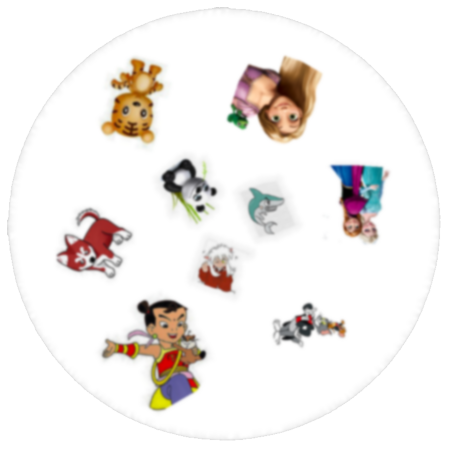

In [540]:
card_cnt = CV2Contour.grab_by_area(img_bin)[0]
card_img = CV2Contour.make_white_background(img_gaussian, card_cnt)
CV2Image.show(card_img)

11


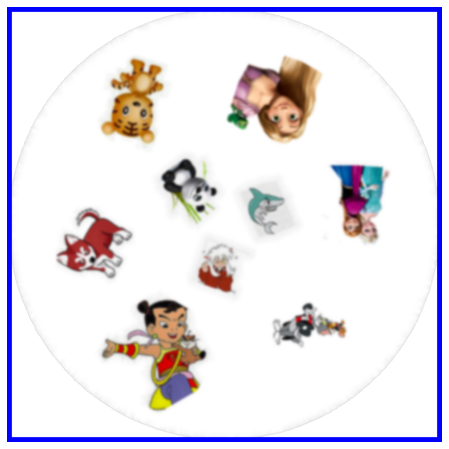

In [547]:
card_img_gray = CV2Image.to_gray(card_img)
card_img_bin = CV2Image.to_thresh(card_img_gray, threshold=210)
cnts_top10 = CV2Contour.grab_by_area(card_img_bin, area=900)[:10]
for cnt in cnts_top10:
    img = CV2Contour.on_draw(card_img, cnt)
    CV2Image.show(img)

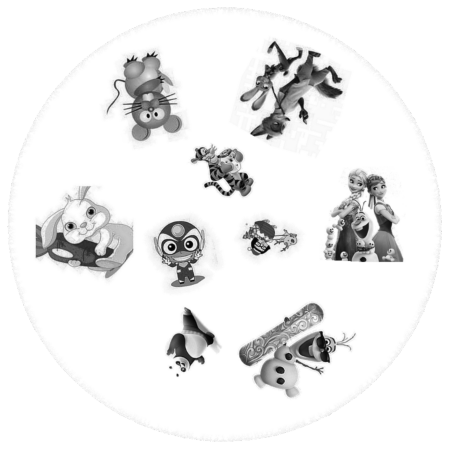

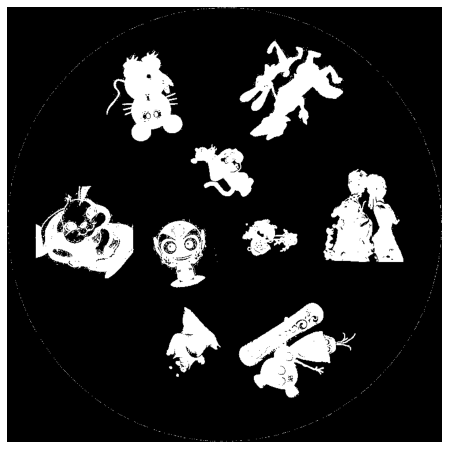

In [349]:
## detect 10 icons
img_card_gray = cv2.cvtColor(img_card, cv2.COLOR_BGR2GRAY)
im_show(img_card_gray, gray=True, bgr=True)

img_card_threshold = cv2.threshold(img_card_gray, 220, 255, cv2.THRESH_BINARY_INV)[1]
im_show(img_card_threshold, gray=True)

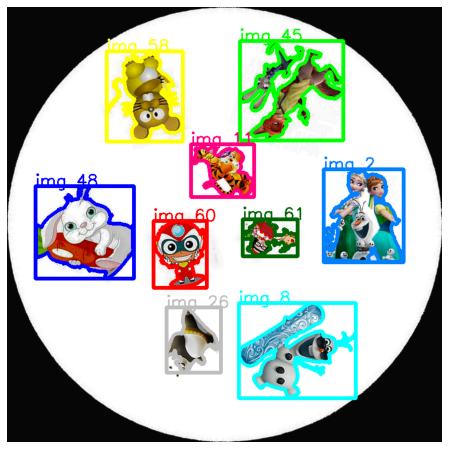

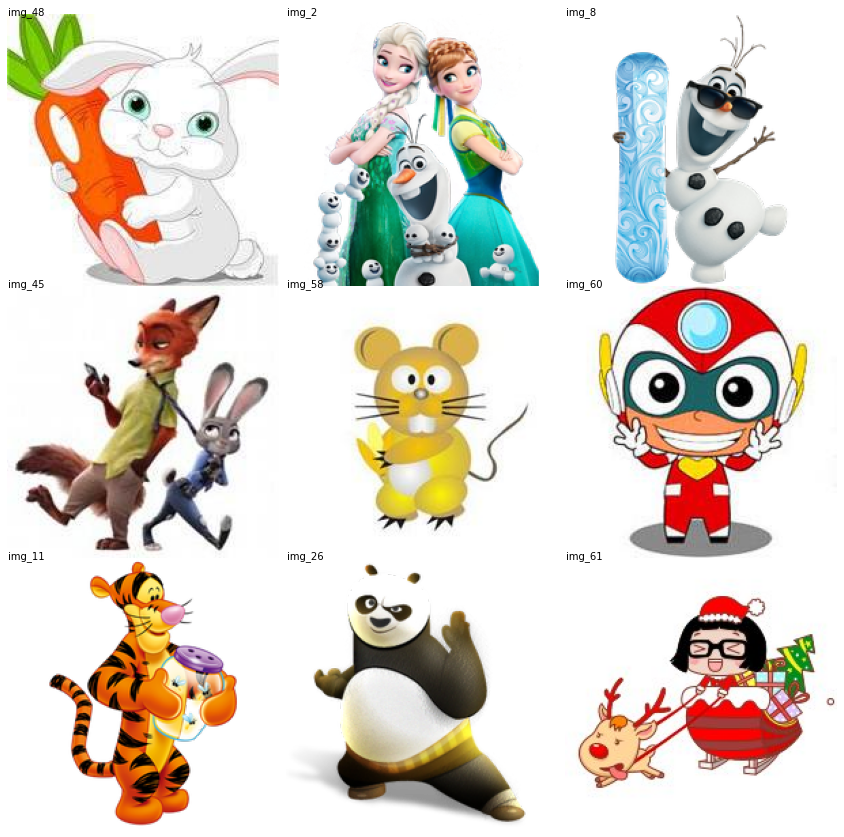

In [398]:
cnts, _ = cv2.findContours(img_card_threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = [c for c in cnts if cv2.contourArea(c) > 900]
conts_sorted = sorted(cnts, key=cv2.contourArea, reverse=True)

colors = [
    (255, 0, 0),     # 赤
    (255, 128, 0),   # 橙
    (255, 255, 0),   # 黄
    (0, 255, 0),     # 绿
    (0, 255, 255),   # 青
    (0, 0, 255),     # 蓝
    (128, 0, 255),   # 紫
    (190, 190, 190), # 灰
    (0, 100, 0),     # 深绿
]

images = { osp.basename(imgpath).split('.')[0] : cv2.imread(imgpath, cv2.IMREAD_UNCHANGED) for imgpath in images73}
targets = []
img_cnt = img_contrast_resize800.copy()
for i, cnt in enumerate(conts_sorted[0:len(colors)]):
    cv2.drawContours(img_cnt, [cnt], -1, colors[i], 5)
    x, y, w, h = cv2.boundingRect(cnt)
    # if w < h:
    #     x += int((h - w) / 2)
    #     w = h
    # else:
    #     y += int((w - h) / 2 )
    #     h = w
    img_icon = img_cnt[y:y+h, x:x+w]
    cv2.rectangle(img_cnt, (x,y), (x+w,y+h), color=colors[i], thickness=5)
    
    sift = cv2.xfeatures2d.SIFT_create()
    kp_1, desc_1 = sift.detectAndCompute(img_icon, None)
    index_params = dict(algorithm=0, trees=5)
    search_params = dict()
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    result = []
    for img_id, (keypoints, descriptors) in feature_items_.items():
        kp_2, desc_2 = keypoints, descriptors
        matches = calculate_matches(flann, desc_1, desc_2)
        score = 100 * (len(matches)/min(len(kp_1), len(kp_2)))
        result.append((score, img_id)) 
    img_id = f'{max(result, key=lambda x: x[0])[1]}'
    cv2.putText(img_cnt, img_id, (x, y),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.0,
                color=colors[i], thickness=2)
    targets.append((img_id, images[img_id], img_icon))
im_show(img_cnt, bgr=True)

nrow, ncol = 3, 3
fig = plt.figure(figsize=(5*nrow, 5*ncol))
for i in range(nrow*ncol):
    ax = fig.add_subplot(nrow, ncol, i+1)
    plt.axis('off')
    plt.text(0, 0, targets[i][0])
    plt.imshow(cv2.cvtColor(targets[i][1], cv2.COLOR_BGR2RGBA))
plt.subplots_adjust(wspace =0, hspace =0)